***Lectura de Imágenes***

In [1]:
import os
import zipfile
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.mixed_precision import Policy, set_global_policy

In [2]:
# Selección de clases
num_categories = 10

images_dir = os.path.join(os.path.dirname(os.getcwd()), "Clasificador-Minerales", "images_processed")
all_classes = sorted(os.listdir(images_dir))
selected_classes = all_classes[:num_categories]

In [3]:
print(f"{num_categories} clases seleccionadas:")
for c in selected_classes:
    print(c.split("_")[0])

10 clases seleccionadas:
Amethyst
Azurite
Calcite
Copper
Fluorite
Malachite
Pyrite
Pyromorphite
Quartz
Wulfenite


In [4]:
# Generador de imágenes con aumento de datos
img_height = 96
img_width = 96
val_split=0.15
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=val_split,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generador del conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    images_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    classes=selected_classes,
    shuffle=True
)

# Generador del conjunto de validación
validation_generator = train_datagen.flow_from_directory(
    images_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    classes=selected_classes,
    shuffle=False
)

Found 42500 images belonging to 10 classes.
Found 7500 images belonging to 10 classes.


In [5]:
# Agrega repetición y precarga
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_categories), dtype=tf.float32)
    )
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_categories), dtype=tf.float32)
    )
)

train_dataset = train_dataset.repeat().prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.repeat().prefetch(tf.data.AUTOTUNE)

***Definición de los modelos***

In [10]:
import visualkeras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [14]:
# Parámetros usados para entrenar

# Tamaño del filtro
kernel_size = (3, 3)

# Funciones de activación
layer_activation = "relu"
output_activation = "softmax"

# Tamaño después de convolución
padding = "same"

# Reducción
pool_size = (2, 2)

# Optimizador
optimizer = "adam"

# Medición del rendimiento
loss = "categorical_crossentropy"
metrics = ["accuracy"]

# Duración del entrenamiento
epochs = 15

# Ajusta dinámicamente la tasa de entrenamiento cuando no hay mejora
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.8,
    patience=2,
    min_lr=5e-6
)

callbacks = [reduce_lr]

***Modelo 1***

In [17]:
# Arquitectura de modelo
model_1 = models.Sequential([

    # Entrada
    layers.Input(shape=(img_height, img_width, 3)),
    
    # Capa 1
    layers.Conv2D(32, kernel_size, activation=layer_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size),

    # Capa 2
    layers.Conv2D(64, kernel_size, activation=layer_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size),

    # Capa 3
    layers.Conv2D(128, kernel_size, activation=layer_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size),

    # Capa 4
    layers.Conv2D(256, kernel_size, activation=layer_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size),

    # Capa 5
    layers.Conv2D(512, kernel_size, activation=layer_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size),

    # Aplanamiento global
    layers.GlobalAveragePooling2D(),

    # Capa densa 1
    layers.Dense(256, activation=layer_activation),
    layers.BatchNormalization(),

    # Capa densa 2
    layers.Dense(128, activation=layer_activation),
    layers.BatchNormalization(),

    # Capa de salida
    layers.Dense(num_categories, activation=output_activation)
])

In [19]:
# Compilación del modelo
model_1.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [21]:
# Resumen del modelo
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,739,594 (6.64 MB)

 Trainable params: 1,736,842 (6.63 MB)

 Non-trainable params: 2,752 (10.75 KB)

C:\Users\Victor Mendez\AppData\Roaming\Python\Python312\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


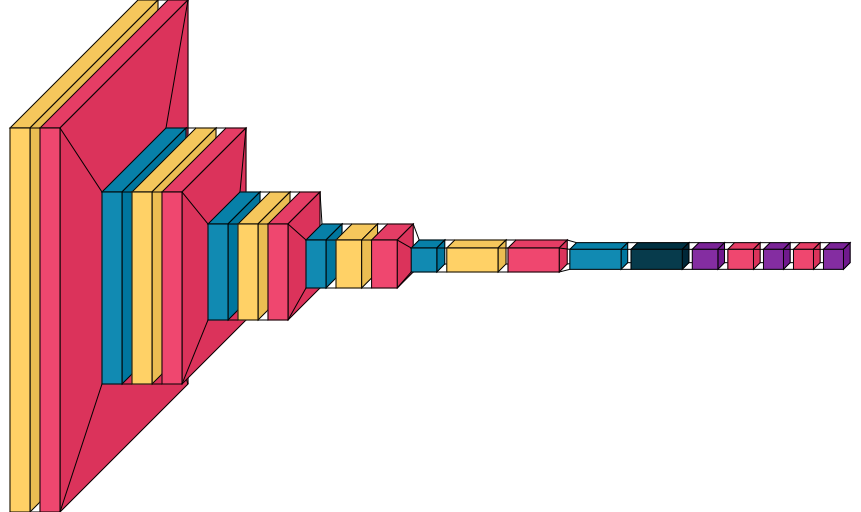

In [23]:
# Visualización del modelo
visualkeras.layered_view(model_1)

In [25]:
# Entrenamiento
history_1 = model_1.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_dataset,
    validation_steps=validation_generator.samples // batch_size,
    steps_per_epoch=train_generator.samples // batch_size,
)

Epoch 1/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 356s 524ms/step - accuracy: 0.4432 - loss: 1.6308 - val_accuracy: 0.4590 - val_loss: 1.5664 - learning_rate: 0.0010
Epoch 2/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 396s 597ms/step - accuracy: 0.5549 - loss: 1.2843 - val_accuracy: 0.5206 - val_loss: 1.3690 - learning_rate: 0.0010
Epoch 3/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 373s 561ms/step - accuracy: 0.5939 - loss: 1.1820 - val_accuracy: 0.5473 - val_loss: 1.2987 - learning_rate: 0.0010
Epoch 4/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 367s 553ms/step - accuracy: 0.6099 - loss: 1.1296 - val_accuracy: 0.5399 - val_loss: 1.3318 - learning_rate: 0.0010
Epoch 5/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 367s 553ms/step - accuracy: 0.6203 - loss: 1.0907 - val_accuracy: 0.5745 - val_loss: 1.1958 - learning_rate: 0.0010
Epoch 6/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 359s 540ms/step - accuracy: 0.6288 - loss: 1.0683 - val_accuracy: 0.5764 - val_loss: 1.1799 - learning_rate: 0.0010
Epoch 7/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 348s 524ms/step - accura

***Modelo 2***

In [28]:
# Arquitectura de modelo
model_2 = models.Sequential([

    # Entrada
    layers.Input(shape=(img_height, img_width, 3)),
    
    # Capa 1
    layers.Conv2D(32, kernel_size, activation=layer_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size),

    # Capa 2
    layers.Conv2D(64, kernel_size, activation=layer_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size),

    # Capa 3
    layers.Conv2D(128, kernel_size, activation=layer_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size),

    # Capa 4
    layers.Conv2D(256, kernel_size, activation=layer_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size),

    # Aplanamiento global
    layers.GlobalAveragePooling2D(),

    # Capa densa
    layers.Dense(512, activation=layer_activation),
    layers.BatchNormalization(),

    # Capa de salida
    layers.Dense(num_categories, activation=output_activation)
])

In [30]:
# Compilación del modelo
model_2.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [32]:
# Resumen del modelo
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 529,098 (2.02 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 1,984 (7.75 KB)

C:\Users\Victor Mendez\AppData\Roaming\Python\Python312\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


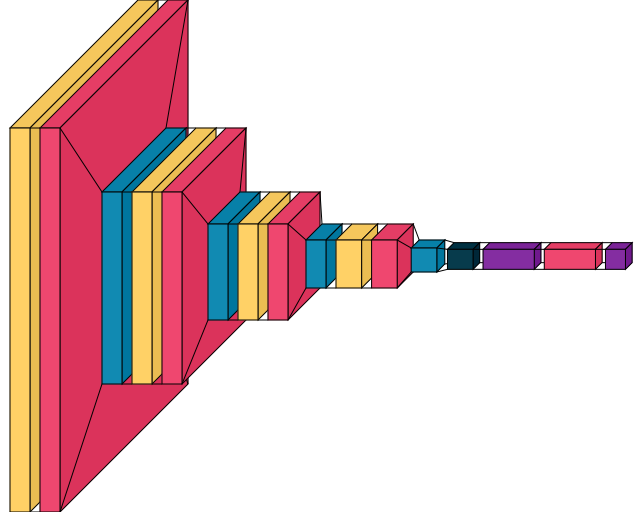

In [34]:
# Visualización del modelo
visualkeras.layered_view(model_2)

In [36]:
# Entrenamiento
history_2 = model_2.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_dataset,
    validation_steps=validation_generator.samples // batch_size,
    steps_per_epoch=train_generator.samples // batch_size,
)

Epoch 1/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 312s 464ms/step - accuracy: 0.4393 - loss: 1.6616 - val_accuracy: 0.4720 - val_loss: 1.5662 - learning_rate: 0.0010
Epoch 2/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 313s 472ms/step - accuracy: 0.5417 - loss: 1.3492 - val_accuracy: 0.5456 - val_loss: 1.3127 - learning_rate: 0.0010
Epoch 3/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 312s 470ms/step - accuracy: 0.5683 - loss: 1.2498 - val_accuracy: 0.5013 - val_loss: 1.5784 - learning_rate: 0.0010
Epoch 4/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 312s 469ms/step - accuracy: 0.5874 - loss: 1.1923 - val_accuracy: 0.5421 - val_loss: 1.3023 - learning_rate: 0.0010
Epoch 5/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 310s 468ms/step - accuracy: 0.6115 - loss: 1.1202 - val_accuracy: 0.5561 - val_loss: 1.2962 - learning_rate: 0.0010
Epoch 6/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 309s 465ms/step - accuracy: 0.6208 - loss: 1.0901 - val_accuracy: 0.5303 - val_loss: 1.3543 - learning_rate: 0.0010
Epoch 7/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 305s 459ms/step - accura

***Modelo 3***

In [39]:
# Arquitectura de modelo
model_3 = models.Sequential([

    # Entrada
    layers.Input(shape=(img_height, img_width, 3)),
    
    # Capa 1
    layers.Conv2D(64, (5, 5), activation=layer_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size),

    # Capa 2
    layers.Conv2D(128, (5, 5), activation=layer_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size),

    # Capa 3
    layers.Conv2D(256, kernel_size, activation=layer_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size),

    # Capa 4
    layers.Conv2D(512, kernel_size, activation=layer_activation, padding=padding),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size),

    # Aplanamiento global
    layers.GlobalAveragePooling2D(),

    # Capa densa
    layers.Dense(256, activation=layer_activation),
    layers.BatchNormalization(),

    # Capa de salida
    layers.Dense(num_categories, activation=output_activation)
])

In [41]:
# Compilación del modelo
model_3.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [43]:
# Resumen del modelo
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 96, 96, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 96, 96, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 48, 48, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,823,882 (6.96 MB)

 Trainable params: 1,821,450 (6.95 MB)

 Non-trainable params: 2,432 (9.50 KB)

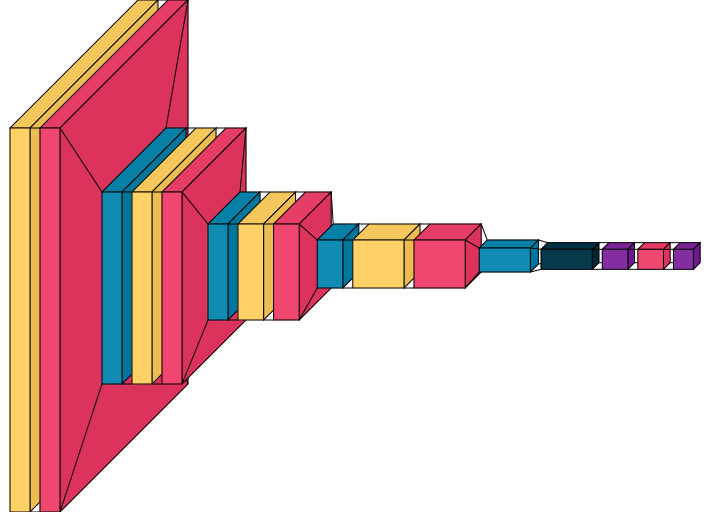

In [45]:
# Visualización del modelo
visualkeras.layered_view(model_3)

In [47]:
# Entrenamiento
history_3 = model_3.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_dataset,
    validation_steps=validation_generator.samples // batch_size,
    steps_per_epoch=train_generator.samples // batch_size,
)

Epoch 1/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 906s 1s/step - accuracy: 0.4267 - loss: 1.6989 - val_accuracy: 0.4493 - val_loss: 1.6035 - learning_rate: 0.0010
Epoch 2/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 918s 1s/step - accuracy: 0.5271 - loss: 1.3733 - val_accuracy: 0.3151 - val_loss: 2.9639 - learning_rate: 0.0010
Epoch 3/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 1040s 2s/step - accuracy: 0.5648 - loss: 1.2525 - val_accuracy: 0.4623 - val_loss: 1.6832 - learning_rate: 0.0010
Epoch 4/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 1005s 2s/step - accuracy: 0.5980 - loss: 1.1560 - val_accuracy: 0.4161 - val_loss: 1.7925 - learning_rate: 8.0000e-04
Epoch 5/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 998s 2s/step - accuracy: 0.6077 - loss: 1.1242 - val_accuracy: 0.5658 - val_loss: 1.2535 - learning_rate: 8.0000e-04
Epoch 6/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 949s 1s/step - accuracy: 0.6234 - loss: 1.0796 - val_accuracy: 0.4958 - val_loss: 1.5007 - learning_rate: 8.0000e-04
Epoch 7/15
664/664 ━━━━━━━━━━━━━━━━━━━━ 960s 1s/step - accuracy: 0.6

In [49]:
import matplotlib.pyplot as plt

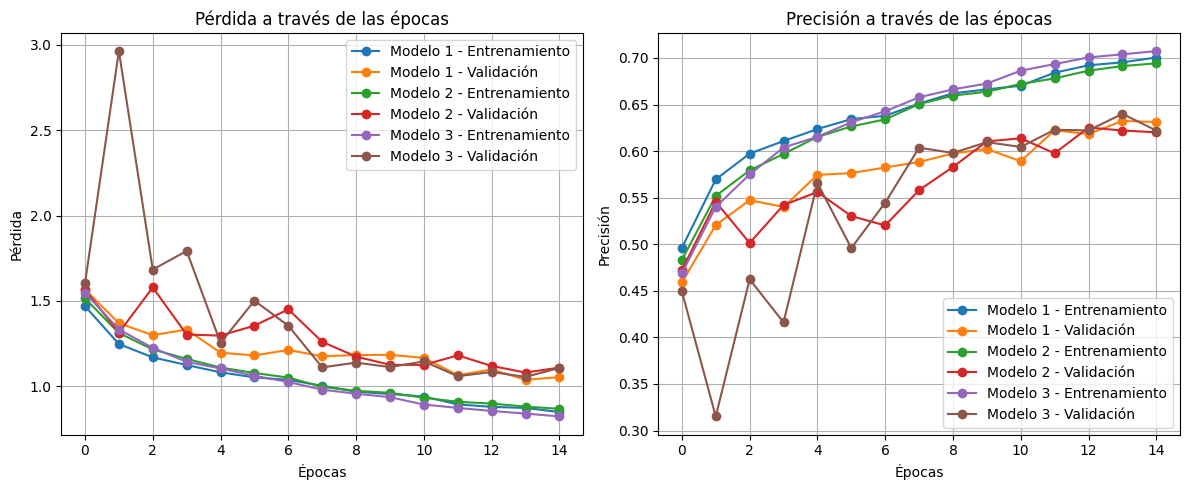

In [53]:
# Extraer métricas de los tres modelos
train_loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']
train_acc_1 = history_1.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']

train_loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']
train_acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']

train_loss_3 = history_3.history['loss']
val_loss_3 = history_3.history['val_loss']
train_acc_3 = history_3.history['accuracy']
val_acc_3 = history_3.history['val_accuracy']

# Crear la figura con dos subgráficas
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Gráfica de pérdida
axs[0].plot(range(epochs), train_loss_1, label='Modelo 1 - Entrenamiento', marker='o')
axs[0].plot(range(epochs), val_loss_1, label='Modelo 1 - Validación', marker='o')
axs[0].plot(range(epochs), train_loss_2, label='Modelo 2 - Entrenamiento', marker='o')
axs[0].plot(range(epochs), val_loss_2, label='Modelo 2 - Validación', marker='o')
axs[0].plot(range(epochs), train_loss_3, label='Modelo 3 - Entrenamiento', marker='o')
axs[0].plot(range(epochs), val_loss_3, label='Modelo 3 - Validación', marker='o')
axs[0].set_title('Pérdida a través de las épocas')
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('Pérdida')
axs[0].legend()
axs[0].grid()

# Gráfica de precisión
axs[1].plot(range(epochs), train_acc_1, label='Modelo 1 - Entrenamiento', marker='o')
axs[1].plot(range(epochs), val_acc_1, label='Modelo 1 - Validación', marker='o')
axs[1].plot(range(epochs), train_acc_2, label='Modelo 2 - Entrenamiento', marker='o')
axs[1].plot(range(epochs), val_acc_2, label='Modelo 2 - Validación', marker='o')
axs[1].plot(range(epochs), train_acc_3, label='Modelo 3 - Entrenamiento', marker='o')
axs[1].plot(range(epochs), val_acc_3, label='Modelo 3 - Validación', marker='o')
axs[1].set_title('Precisión a través de las épocas')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('Precisión')
axs[1].legend()
axs[1].grid()

# Mostrar las gráficas
plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300)
plt.show()